## set running directory

In [1]:
from __future__ import print_function
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir


DATA_PATH = os.path.join(os.environ['RNB_PLANNING_DIR'], "data")
try_mkdir(DATA_PATH)

GF_DATA_PATH = os.path.join(DATA_PATH, "gf2d")
try_mkdir(GF_DATA_PATH)

In [3]:

# ROBOT_TYPE = RobotType.indy7
# ROBOT_NAME = "indy0"
# TOOL_LINK = "indy0_tcp"
# TOOL_LINK_BUNDLE = ["indy0_tcp", "indy0_link6"]
# TOOL_XYZ = (0,0,0.14)
# GRIP_DEPTH = 0.05
# VISUALIZE = False
HOME_POSE = (0,0,0,0,0,0)

ROBOT_TYPE = RobotType.panda
ROBOT_NAME = "panda0"
TOOL_LINK = "panda0_hand"
TOOL_LINK_BUNDLE = ["panda0_hand", "panda0_link6"]
TOOL_XYZ = (0,0,0.112)
GRIP_DEPTH = 0.03
VISUALIZE = False
HOME_POSE = (0,-0.3,0,-0.5,0,2.5,0)


TOOL_RPY = (-np.pi/2,0,0)
CLEARANCE = 1e-3
TIMEOUT_REACH = 1
TIMEOUT_RETRIEVE = 3

assert TOOL_LINK_BUNDLE[0] == TOOL_LINK, "TOOL_LINK_BUNDLE should be in reverse order including actor's link as the first item"

## init combined robot config

In [4]:

from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, ROBOT_TYPE, None,
                None)]
              , connection_list=[False])
ROBOT_NAME = crob.robot_names[0]

connection_list
[False]


In [5]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None, base_link="base_link")
# s_builder.reset_reference_coord(ref_name="floor")

## get ghnd with detected robot config

In [6]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {ROBOT_NAME: ((0,0,0), (0,0,0))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob, start_rviz=VISUALIZE)
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)


In [7]:
from pkg.utils.joint_utils import get_tf
shoulder_link = gscene.urdf_content.joint_map[gscene.joint_names[1]].child
shoulder_height = get_tf(shoulder_link, HOME_DICT, gscene.urdf_content)[2,3]

## add environment

In [8]:
from pkg.geometry.geometry import *

In [9]:
gtems_robot = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True, exclude_link=["panda1_link7"])

## init planning scene

In [10]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

## Register binders

In [11]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepTool

In [12]:
gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip0", link_name=TOOL_LINK, 
                 dims=(0.01,)*3, center=TOOL_XYZ, rpy=TOOL_RPY, color=(1,0,0,1), display=True, collision=False, fixed=True)
gripper = pscene.create_binder(bname="grip0", gname="grip0", rname=ROBOT_NAME, _type=Gripper2Tool, point=(0,0,0), rpy=(0,0,0))

## planner

In [13]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
mplan = MoveitPlanner(pscene)

checkers=[]
gcheck = GraspChecker(pscene, end_link_couple_dict= {TOOL_LINK: TOOL_LINK_BUNDLE, "base_link":["base_link"]})
checkers.append(gcheck)
rcheck = ReachChecker(pscene)
checkers.append(rcheck)
# lcheck = LatticedChecker(pscene, end_link_couple_dict= {TOOL_LINK: TOOL_LINK_BUNDLE, "base_link":["base_link"]})
# checkers.append(lcheck)


## ui

In [14]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


# Object Classes

In [15]:
from pkg.utils.gjk import get_point_list, get_gjk_distance
from pkg.planning.constraint.constraint_subject import CustomObject, Grasp2Point, PlacePoint, SweepPoint, SweepTask

##
# @class ObstacleBase
# @brief base class for obstacle generators
class ObstacleBase:
    RTH_MIN = None ## R: center ~ nearest point
    RTH_MAX = None
    RPY_MIN = None
    RPY_MAX = None
    DIM_MIN = None
    DIM_MAX = None
    GTYPE = None
    COLOR = (0.7,0.7,0.7,1)
    
    def __init__(self, gscene, name, sampler=np.random.uniform, DIM=None, RTH=None, RPY=None):
        self.name = name
        self.DIM = sampler(self.DIM_MIN, self.DIM_MAX) if DIM is None else DIM
        self.RTH = sampler(self.RTH_MIN, self.RTH_MAX) if RTH is None else RTH
        self.RPY = sampler(self.RPY_MIN, self.RPY_MAX) if RPY is None else RPY
        self.RPY[2] += self.RTH[1]
        self.XYZ = np.array(cyl2cart(*self.RTH))
        verts_rotated = np.matmul(Rot_rpy(self.RPY), (DEFAULT_VERT_DICT[self.GTYPE]*self.DIM).transpose())
        xy_normed = self.XYZ[:2]/(np.linalg.norm(self.XYZ[:2])+1e-6)
        verts_r_compo = np.dot(xy_normed, verts_rotated[:2,:])
        self.XYZ[:2] -= xy_normed[:2]*np.min(verts_r_compo)
        self.RTH[0] -= np.min(verts_r_compo)
        self.geometry = gscene.create_safe(gtype=self.GTYPE, name=self.name, link_name="base_link", 
                                  dims=self.DIM, center=tuple(self.XYZ), rpy=self.RPY,
                                  color=self.COLOR, display=True, collision=True, fixed=True)
        self.subgeo_list = []
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_me, raddii_me = self.geometry.get_vertice_radius()
        verts_me_global = np.add(np.matmul(verts_me, self.geometry.orientation_mat.transpose()), 
                                 self.geometry.center)
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_me_global))-radii-raddii_me < 1e-4
        
##
# @class WorkPlane
# @brief working plane. target and obstacle objects are generated on this plane
class WorkPlane(ObstacleBase):
    RTH_MIN = (0.2, 0, -0.05)
    RTH_MAX = (0.2, 0, 0.35)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (1, 1, 0.1)
    DIM_MAX = (1, 1, 0.1)
    GTYPE = GEOTYPE.BOX
    COLOR=  (0.8,0.8,0.2,0.5)
    
    def __init__(self, gscene, name, *args, **kwargs):
        ObstacleBase.__init__(self, gscene, name, *args, **kwargs)
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_wp = np.multiply(DEFAULT_VERT_DICT[self.GTYPE], tuple(self.DIM[:2])+(self.H,))
        verts_wp_global = np.add(np.matmul(verts_wp, self.geometry.orientation_mat.transpose()), 
                                 np.add(self.geometry.center, (0,0,self.H/2)))
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_wp_global))-radii < 1e-4
    
##
# @class PlaneObstacle
# @brief Obstacles on the workplane
class PlaneObject(ObstacleBase):
    RTH_MIN = (0.3, -np.pi/2, -0.2)
    RTH_MAX = (0.8, +np.pi/2, +0.5)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (0.02, GRIP_DEPTH, GRIP_DEPTH)
    DIM_MAX = (0.1, 0.3, 0.3)
    GTYPE = GEOTYPE.BOX
    COLOR =  (0.2,0.2,0.8,0.5)
    def __init__(self, gscene, name, workplane, XYZ_LOC=None, **kwargs):
        ObstacleBase.__init__(self, gscene=gscene, name=name, **kwargs)
        verts, radii = self.geometry.get_vertice_radius()
        verts_rot = np.matmul(self.geometry.orientation_mat, verts.transpose()) ## verices with global orientaion
        verts_rot_loc = np.matmul(workplane.geometry.Toff[:3,:3].transpose(), verts_rot) ## verices with local orientaion
        max_verts = np.max(verts_rot_loc, axis=-1)
        min_verts = np.min(verts_rot_loc, axis=-1)
        if XYZ_LOC is None:
            self.XYZ_LOC = np.random.uniform(np.negative(workplane.DIM)/2-min_verts+radii,np.array(workplane.DIM)/2-max_verts-radii)
            self.XYZ_LOC[2] = workplane.DIM[2]/2 + self.DIM[2]/2 + CLEARANCE
        else:
            self.XYZ_LOC = self.XYZ_LOC
        self.XYZ = np.matmul(workplane.geometry.Toff[:3,:3], self.XYZ_LOC) + workplane.geometry.Toff[:3,3]
        self.RPY = (0,0,0)
        self.geometry.set_offset_tf(center = self.XYZ, orientation_mat=Rot_rpy(self.RPY))
        self.RTH = cart2cyl(*self.XYZ)
        gscene.update_marker(self.geometry)
        
        
def clear_class(gscene, key, Nmax):
    for iw in range(Nmax):
        gname = "{}_{}".format(key, iw)
        if gname in gscene.NAME_DICT:
            gscene.remove(gscene.NAME_DICT[gname])

            
def disperse_objects(gscene, object_class, key, Nobj, workplane_on):
    clear_class(gscene, key, Nobj)
        
    obs_list = []
    for iw in range(Nobj):
        while len(obs_list) != iw+1:
            obs = object_class(gscene, "{}_{}".format(key, iw), workplane_on)
            remove_this = False
            for obs_pre in obs_list:
                if obs_pre.is_overlapped_with(obs.geometry):
                    remove_this = True
                    break
            if remove_this:
                gscene.remove(obs.geometry)
            else:
                obs_list.append(obs)
    return obs_list


def add_object(pscene, obj, HANDLE_THICKNESS=1e-6, HANDLE_COLOR = (1,0,0,0.3)):
    gscene = pscene.gscene
    handles = []
    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_a", link_name="base_link", 
                       dims=(GRIP_DEPTH, obj.DIM[1],HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(0,np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_b", link_name="base_link", 
                       dims=(GRIP_DEPTH, obj.DIM[1],HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(0,np.pi/2,0), 
                       color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                   parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    action_points_dict = {"placement": PlacePoint("placement", obj.geometry, [0,0,-obj.DIM[2]/2], [0,0,0])}
    action_points_dict.update({handle.name: Grasp2Point(handle.name, handle, None, (0,0,0)) for handle in handles})
    obj_pscene = pscene.create_object(oname=obj.name, gname=obj.name, _type=CustomObject, 
                                 action_points_dict=action_points_dict)
    return obj_pscene, handles

def get_geometric_feature(object_geo, obstacle_geo, workplane):
    xvec = [1,0,0]
    xvec_obj = np.matmul(object_geo.orientation_mat, xvec)
    theta_obj = np.arctan2(xvec_obj[1], xvec_obj[0])
    theta_obj_loc = (theta_obj+np.pi/4)%(np.pi/2)-np.pi/4
    theta_obj_step = theta_obj - theta_obj_loc
    xvec_obs = np.matmul(obstacle_geo.orientation_mat, xvec)
    theta_obs = np.arctan2(xvec_obs[1], xvec_obs[0])
    theta_obs_loc = (theta_obs+np.pi/4)%(np.pi/2)-np.pi/4
    theta_obs_step = theta_obs - theta_obs_loc
    
    delta_cylcoord = cart2cyl(*np.subtract(obstacle_geo.center, object_geo.center))[:2]
    delta_cylcoord = list(delta_cylcoord) + [delta_cylcoord[1]**2]
    return list(np.matmul(Rot_axis(3, theta_obj_step), object_geo.dims))+\
            list(np.matmul(Rot_axis(3, theta_obs_step), obstacle_geo.dims))+\
            list(cart2cyl(*object_geo.center)[:2])+list(cart2cyl(*obstacle_geo.center)[:2])+delta_cylcoord+\
            [workplane.RTH[2], theta_obj_loc, theta_obs_loc]

ROTBINDING_LIST = [(False, 'hdl_tp_a'), (False, 'hdl_tp_b'),
                    (False, 'hdl_ft_a'), (False, 'hdl_ft_b'),
                    (False, 'hdl_bk_a'), (False, 'hdl_bk_b'),
                    (True, 'hdl_tp_a'), (True, 'hdl_tp_b'),
                    (True, 'hdl_ft_a'), (True, 'hdl_ft_b'),
                    (True, 'hdl_bk_a'), (True, 'hdl_bk_b')
                   ]

FIXED_REDUNDANCY_DICT = {'hdl_tp_a':-np.pi/2, 'hdl_tp_b':np.pi/2, 
                         'hdl_ft_a': 0, 'hdl_ft_b': 0, 
                         'hdl_bk_a': np.pi, 'hdl_bk_b': np.pi}

ROBOT_DATA_ROOT = os.path.join(GF_DATA_PATH, ROBOT_TYPE.name)
try_mkdir(ROBOT_DATA_ROOT)

## collect trainset

In [16]:
N_max_sample = 100
N_print = 20

i_s = 0
i_print = 0
features_dat_dict = {k: [] for k in ROTBINDING_LIST}
reach_list_dict = {k: [] for k in ROTBINDING_LIST}
retrieve_list_dict = {k: [] for k in ROTBINDING_LIST}
reach_list = []
retrieve_list = []
gtimer = GlobalTimer.instance()
gtimer.reset()
gtimer.tic("full_loop")
while i_s < N_max_sample:
    ## set workplane
    wp = WorkPlane(gscene, "wp")
    pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane)

    ## add object
    obj_list = disperse_objects(gscene, PlaneObject, "obj", 2, workplane_on=wp)

    obj = obj_list[0]
    SHOW_PERIOD = 0.05
    N_sample = 1000
    obj_pscene, handles = add_object(pscene, obj)
    mplan.update_gscene()
    
    for rotate_obj in [False, True]:
        if rotate_obj:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,np.pi/2))
        else:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,0))
        obj_pscene.geometry.set_offset_tf(orientation_mat=np.matmul(obj_pscene.geometry.orientation_mat, 
                                                                    np.random.uniform(-np.pi/4, np.pi/4-1e-6)))
            
        for obj_tmp in obj_list[1:]:
            Rot_candis = [Rot_axis(3,np.pi/2), Rot_axis(3,0)]
            i_rot = random.choice([0,1])
            obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[i_rot])
            obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                     np.random.uniform(-np.pi/4, np.pi/4-1e-6)))
            if obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[(i_rot+1)%2])
                obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                         np.random.uniform(-np.pi/4, np.pi/4-1e-6)))
            while obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obs = obj_tmp.__init__(gscene, obj_tmp.name, wp)

        initial_state = pscene.update_state(HOME_POSE)
        pscene.set_object_state(initial_state)
        from_state = initial_state.copy(pscene)
        to_node = ("grip0",)

        bp_list = [rotbd[1] for rotbd in ROTBINDING_LIST if rotbd[0]==rotate_obj]
        for bp in bp_list:
            to_state, redundancy_dict = pscene.sample_leaf_state(from_state, {'obj_0': [(bp, 'grip0', 'grip0')]}, to_node)
            redundancy_dict['obj_0']['grip0']['w'] = FIXED_REDUNDANCY_DICT[bp]
            redundancy_dict['obj_0'][bp]['w'] = 0
            redundancy_dict['obj_0'][bp]['x'] = 0
            redundancy_dict['obj_0'][bp]['y'] = 0

            success_reach, success_retrieve = False, False
            Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
            #             print("reach: {}".format(success_reach))
            Traj_retrieve = []
            if success_reach:
                if VISUALIZE:
                    gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                end_state = new_state.copy(pscene)
                end_state.Q = np.array(HOME_POSE)
                Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                    from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)
            #                 print("retrieve: {}".format(success_retrieve))
                if success_retrieve and VISUALIZE:
                    gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)
            features_dat_dict[(rotate_obj, bp)].append(get_geometric_feature(gscene.NAME_DICT['obj_0'], gscene.NAME_DICT['obj_1'], wp))
            reach_list_dict[(rotate_obj, bp)].append(success_reach)
            retrieve_list_dict[(rotate_obj, bp)].append(success_retrieve)
            reach_list.append(success_reach)
            retrieve_list.append(success_retrieve)
            pscene.set_object_state(initial_state)
            gscene.update_markers_all()
            ####################### test #########################
            break
            ######################################################
            
        ####################### test #########################
        break
        ######################################################
            
    ####################### test #########################
    break
    ######################################################
    i_s += 1
    gscene.update_markers_all()
    if i_s > 0 :
        if i_s > i_print*N_print:
            i_print +=  1
            print_end = "\n"
        else:
            print_end = "\r"
        time_elapsed = gtimer.toc("full_loop")/1000
        print("{} / {} in {} / {} s -- reach,retrieve = ({} %, {} %)                     ".format(
            i_s, N_max_sample, round(time_elapsed, 2), round(time_elapsed/i_s*N_max_sample, 2), 
            round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1)), end=print_end)

time_elapsed = gtimer.toc("full_loop")/1000
print("")
print("")
print("============= Finished {} in {} s -- reach,retrieve = ({} %, {} %) =================".format(
    i_s, round(time_elapsed, 2), round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1)))

1 / 100 in 6.24 / 624.03 s -- reach,retrieve = (58.3 %, 58.3 %)                     
21 / 100 in 215.04 / 1023.98 s -- reach,retrieve = (19.8 %, 19.8 %)                     
41 / 100 in 453.58 / 1106.29 s -- reach,retrieve = (12.2 %, 12.2 %)                     
61 / 100 in 653.72 / 1071.67 s -- reach,retrieve = (16.0 %, 16.0 %)                     
81 / 100 in 858.19 / 1059.49 s -- reach,retrieve = (17.6 %, 17.6 %)                     
100 / 100 in 1037.58 / 1037.58 s -- reach,retrieve = (19.9 %, 19.9 %)                     

============= Finished 100 in 1037.58 s -- reach,retrieve = (19.9 %, 19.9 %) =================


In [ ]:
get_geometric_feature(gscene.NAME_DICT['obj_0'], gscene.NAME_DICT['obj_1'], wp)

## save data

In [17]:
DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, get_now())
try_mkdir(DATASET_PATH)

save_pickle(os.path.join(DATASET_PATH, "train_dat.pkl"), 
            {"features_dat_dict": features_dat_dict, "retrieve_list_dict": retrieve_list_dict})

## load data

In [18]:
DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, sorted(os.listdir(ROBOT_DATA_ROOT))[-1])

train_dat = load_pickle(os.path.join(DATASET_PATH, "train_dat.pkl"))
features_dat_dict = train_dat["features_dat_dict"]
retrieve_list_dict = train_dat["retrieve_list_dict"]

## collect testset

In [19]:
N_max_sample = 50
N_print = 10

i_s = 0
i_print = 0
features_dat_dict = {k: [] for k in ROTBINDING_LIST}
reach_list_dict = {k: [] for k in ROTBINDING_LIST}
retrieve_list_dict = {k: [] for k in ROTBINDING_LIST}
feature_time_list = []
filter_results_dict =  {checker.__class__.__name__: {k: [] for k in ROTBINDING_LIST} for checker in checkers}
filter_time_dict = {checker.__class__.__name__: [] for checker in checkers}
reach_list = []
retrieve_list = []
gtimer = GlobalTimer.instance()
gtimer.reset()
gtimer.tic("full_loop")
while i_s < N_max_sample:
    ## set workplane
    wp = WorkPlane(gscene, "wp")
    pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane)

    ## add object
    obj_list = disperse_objects(gscene, PlaneObject, "obj", 2, workplane_on=wp)

    obj = obj_list[0]
    SHOW_PERIOD = 0.05
    N_sample = 1000
    obj_pscene, handles = add_object(pscene, obj)
    mplan.update_gscene()
    for rotate_obj in [False, True]:
        if rotate_obj:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,np.pi/2))
        else:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,0))
        obj_pscene.geometry.set_offset_tf(orientation_mat=np.matmul(obj_pscene.geometry.orientation_mat, 
                                                                    np.random.uniform(-np.pi/4, np.pi/4-1e-6)))
            
        for obj_tmp in obj_list[1:]:
            Rot_candis = [Rot_axis(3,np.pi/2), Rot_axis(3,0)]
            i_rot = random.choice([0,1])
            obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[i_rot])
            obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                     np.random.uniform(-np.pi/4, np.pi/4-1e-6)))
            if obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[(i_rot+1)%2])
                obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                         np.random.uniform(-np.pi/4, np.pi/4-1e-6)))
            while obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obs = obj_tmp.__init__(gscene, obj_tmp.name, wp)
            
        initial_state = pscene.update_state(HOME_POSE)
        pscene.set_object_state(initial_state)
        from_state = initial_state.copy(pscene)
        to_node = ("grip0",)

        bp_list = [rotbd[1] for rotbd in ROTBINDING_LIST if rotbd[0]==rotate_obj]
        for bp in bp_list:
            to_state, redundancy_dict = pscene.sample_leaf_state(from_state, {'obj_0': [(bp, 'grip0', 'grip0')]}, to_node)
            redundancy_dict['obj_0']['grip0']['w'] = FIXED_REDUNDANCY_DICT[bp]
            redundancy_dict['obj_0'][bp]['w'] = 0
            redundancy_dict['obj_0'][bp]['x'] = 0
            redundancy_dict['obj_0'][bp]['y'] = 0
            
            for checker in checkers:
                fname = checker.__class__.__name__
                gtimer.tic(fname)
                res = checker.check(gripper, obj_pscene, obj_pscene.action_points_dict[to_state.binding_state[0][1]], redundancy_dict[obj.name], HOME_DICT)
                etime = gtimer.toc(fname)
                filter_time_dict[fname].append(etime)
                filter_results_dict[fname][(rotate_obj, bp)].append(res)

            success_reach, success_retrieve = False, False
            Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
            #             print("reach: {}".format(success_reach))
            Traj_retrieve = []
            if success_reach:
                if VISUALIZE:
                    gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                end_state = new_state.copy(pscene)
                end_state.Q = np.array(HOME_POSE)
                Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                    from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)
            #                 print("retrieve: {}".format(success_retrieve))
                if success_retrieve and VISUALIZE:
                    gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)
            obj_geo, obs_go = gscene.NAME_DICT['obj_0'], gscene.NAME_DICT['obj_1']
            gtimer.tic("get_geometric_feature")
            feature = get_geometric_feature(obj_geo, obs_go, wp)
            feature_time_list.append(gtimer.toc("get_geometric_feature"))
            features_dat_dict[(rotate_obj, bp)].append(feature)
            reach_list_dict[(rotate_obj, bp)].append(success_reach)
            retrieve_list_dict[(rotate_obj, bp)].append(success_retrieve)
            reach_list.append(success_reach)
            retrieve_list.append(success_retrieve)
            pscene.set_object_state(initial_state)
            gscene.update_markers_all()
    i_s += 1
    gscene.update_markers_all()
    if i_s > 0 :
        if i_s > i_print*N_print:
            i_print +=  1
            print_end = "\n"
        else:
            print_end = "\r"
        time_elapsed = gtimer.toc("full_loop")/1000
        print("{} / {} in {} / {} s -- reach,retrieve = ({} %, {} %)                     ".format(
            i_s, N_max_sample, round(time_elapsed, 2), round(time_elapsed/i_s*N_max_sample, 2), 
            round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1)), end=print_end)

time_elapsed = gtimer.toc("full_loop")/1000
print("")
print("")
print("============= Finished {} in {} s -- reach,retrieve = ({} %, {} %) =================".format(
    i_s, round(time_elapsed, 2), round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1)))

1 / 50 in 8.84 / 442.06 s -- reach,retrieve = (33.3 %, 33.3 %)                     
11 / 50 in 97.82 / 444.65 s -- reach,retrieve = (36.4 %, 36.4 %)                     
21 / 50 in 194.61 / 463.37 s -- reach,retrieve = (31.7 %, 31.7 %)                     
31 / 50 in 294.8 / 475.49 s -- reach,retrieve = (29.3 %, 29.3 %)                      
41 / 50 in 387.68 / 472.78 s -- reach,retrieve = (29.5 %, 29.5 %)                     
50 / 50 in 476.73 / 476.73 s -- reach,retrieve = (28.5 %, 28.5 %)                     

============= Finished 50 in 476.73 s -- reach,retrieve = (28.5 %, 28.5 %) =================


## save data

In [20]:
DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, sorted(os.listdir(ROBOT_DATA_ROOT))[-1])

save_pickle(os.path.join(DATASET_PATH, "test_dat.pkl"), 
            {"features_dat_dict": features_dat_dict, "retrieve_list_dict": retrieve_list_dict,
             "filter_results_dict": filter_results_dict,
             "filter_time_dict": filter_time_dict, 
             "feature_time_list": feature_time_list})

## load data

In [21]:
DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, sorted(os.listdir(ROBOT_DATA_ROOT))[-1])

test_dat = load_pickle(os.path.join(DATASET_PATH, "test_dat.pkl"))
features_dat_dict_test = test_dat["features_dat_dict"]
retrieve_list_dict_test = test_dat["retrieve_list_dict"]
filter_results_dict = test_dat["filter_results_dict"]
filter_time_dict = test_dat["filter_time_dict"]
feature_time_list = test_dat["feature_time_list"]

## train model

In [22]:
from sklearn import svm
gtimer = GlobalTimer.instance()

In [23]:
C_svm = 10

train_res_all = []
success_list_all = []
clf_dict = {}
for rotbd in ROTBINDING_LIST:
    feature_mat_train = np.array(features_dat_dict[rotbd])
    label_array = np.array(retrieve_list_dict[rotbd])
    clf_dict[rotbd] = svm.SVC(kernel='rbf', C=C_svm)
    clf_dict[rotbd].fit(feature_mat_train, label_array)
    train_res_all = train_res_all + list(np.equal(clf_dict[rotbd].predict(feature_mat_train), label_array))
    success_list_all = success_list_all + list(label_array)
train_res_all = np.array(train_res_all)

test_res_all = []
success_list_all_test = []
test_time_all = []
for rotbd in ROTBINDING_LIST:
    feature_mat_test = np.array(features_dat_dict_test[rotbd])
    label_array_test = np.array(retrieve_list_dict_test[rotbd])
    for features, label in zip(feature_mat_test, label_array_test):
        clf = clf_dict[rotbd]
        gtimer.tic("predict")
        res = clf.predict(np.array([features]))
        test_time_all.append(gtimer.toc("predict"))
        test_res_all.append(np.equal(res[0], label))
    success_list_all_test = success_list_all_test + list(label_array_test)
test_res_all = np.array(test_res_all)


print("=" * 80)
print("trainning accuracy = {} %".format(round(np.mean(train_res_all) * 100, 2)))
print("trainning success accuracy = {} %".format(
    round(np.mean(train_res_all[np.where(success_list_all)]) * 100, 2)))
print("trainning failure accuracy = {} %".format(
    round(np.mean(train_res_all[np.where(np.logical_not(success_list_all))]) * 100, 2)))
print("=" * 80)
print("test accuracy = {} %".format(round(np.mean(test_res_all) * 100, 2)))
print("test success accuracy = {} %".format(
    round(np.mean(test_res_all[np.where(success_list_all_test)]) * 100, 2)))
print("test failure accuracy = {} %".format(
    round(np.mean(test_res_all[np.where(np.logical_not(success_list_all_test))]) * 100, 2)))
print("-" * 80)
print("feature time = {} ({}/{})ms".format(round(np.mean(feature_time_list), 3), 
                                      round(np.min(feature_time_list), 3), round(np.max(feature_time_list), 3)))
print("inference time = {} ({}/{})ms".format(round(np.mean(test_time_all), 3), 
                                      round(np.min(test_time_all), 3), round(np.max(test_time_all), 3)))
print("=" * 80)

trainning accuracy = 100.0 %
trainning success accuracy = 100.0 %
trainning failure accuracy = 100.0 %
test accuracy = 100.0 %
test success accuracy = 100.0 %
test failure accuracy = 100.0 %
--------------------------------------------------------------------------------
feature time = 0.081 (0.038/0.537)ms
inference time = 0.036 (0.033/0.087)ms


/home/rnb/.local/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



## test filter results

In [24]:
fname_accumm = []
for checker in checkers:
    fname_cur = checker.__class__.__name__
    fname_accumm.append(fname_cur)
    test_res_all = []
    success_list_all_test = []
    for rotbd in ROTBINDING_LIST:
        filter_results = np.all([filter_results_dict[fname][rotbd] for fname in fname_accumm], axis=0)
        label_array_test = np.array(retrieve_list_dict_test[rotbd])
        test_res_all = test_res_all + list(np.equal(filter_results, label_array_test))
        success_list_all_test = success_list_all_test + list(label_array_test)
    test_res_all = np.array(test_res_all)
    filter_times = np.sum([filter_time_dict[fname] for fname in fname_accumm], axis=0)
    print("=" * 80)
    print("{} accuracy = {} %".format(fname_cur, round(np.mean(test_res_all) * 100, 2)))
    print("{} success accuracy = {} %".format(fname_cur,
        round(np.mean(test_res_all[np.where(success_list_all_test)]) * 100, 2)))
    print("{} failure accuracy = {} %".format(fname_cur,
        round(np.mean(test_res_all[np.where(np.logical_not(success_list_all_test))]) * 100, 2)))
    print("-" * 80)
    print("{} time = {} ({}/{})ms".format(fname_cur, round(np.mean(filter_times), 3), 
                                          round(np.min(filter_times), 3), round(np.max(filter_times), 3)))
    print("=" * 80)

GraspChecker accuracy = 66.0 %
GraspChecker success accuracy = 100.0 %
GraspChecker failure accuracy = 52.45 %
--------------------------------------------------------------------------------
GraspChecker time = 1.385 (1.15/39.056)ms
ReachChecker accuracy = 96.0 %
ReachChecker success accuracy = 95.32 %
ReachChecker failure accuracy = 96.27 %
--------------------------------------------------------------------------------
ReachChecker time = 1.666 (1.379/39.363)ms


## test multi object

1 / 50 in 12.35 / 617.4 s -- reach,retrieve = (0.0 %, 0.0 %)                     
11 / 50 in 118.26 / 537.57 s -- reach,retrieve = (18.2 %, 18.2 %)                     
21 / 50 in 208.35 / 496.08 s -- reach,retrieve = (25.4 %, 25.4 %)                     
31 / 50 in 306.08 / 493.68 s -- reach,retrieve = (26.1 %, 26.1 %)                     
41 / 50 in 402.38 / 490.71 s -- reach,retrieve = (26.6 %, 26.6 %)                     
50 / 50 in 502.43 / 502.43 s -- reach,retrieve = (24.2 %, 24.2 %)                     

============= Finished 50 in 502.43 s -- reach,retrieve = (24.2 %, 24.2 %) =================


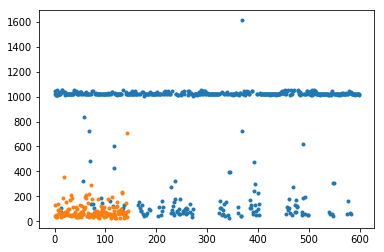

In [25]:
N_obj = 10
N_max_sample = 50
N_print = 10

i_s = 0
i_print = 0
features_dat_dict = {k: {} for k in ROTBINDING_LIST}
reach_list_dict = {k: [] for k in ROTBINDING_LIST}
retrieve_list_dict = {k: [] for k in ROTBINDING_LIST}
filter_results_dict =  {checker.__class__.__name__: {k: [] for k in ROTBINDING_LIST} for checker in checkers}
filter_time_dict = {checker.__class__.__name__: [] for checker in checkers}
feature_time_list = []
reach_list = []
retrieve_list = []
gtimer = GlobalTimer.instance()
gtimer.reset()
gtimer.tic("full_loop")
reach_time_log = []
retrieve_time_log = []
while i_s < N_max_sample:
    ## set workplane
    wp = WorkPlane(gscene, "wp")
    pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane)

    ## add object
    obj_list = disperse_objects(gscene, PlaneObject, "obj", N_obj, workplane_on=wp)
    obj_names = [obj_tmp.name for obj_tmp in obj_list]

    obj = obj_list[0]
    SHOW_PERIOD = 0.05
    N_sample = 1000
    obj_pscene, handles = add_object(pscene, obj)
    mplan.update_gscene()
    for rotate_obj in [False, True]:
        if rotate_obj:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,np.pi/2))
        else:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,0))
        obj_pscene.geometry.set_offset_tf(orientation_mat=np.matmul(obj_pscene.geometry.orientation_mat, 
                                                                    np.random.uniform(-np.pi/4, np.pi/4-1e-6)))
            
        for obj_tmp in obj_list[1:]:
            Rot_candis = [Rot_axis(3,np.pi/2), Rot_axis(3,0)]
            i_rot = random.choice([0,1])
            obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[i_rot])
            obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                     np.random.uniform(-np.pi/4, np.pi/4-1e-6)))
            if obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[(i_rot+1)%2])
                obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                         np.random.uniform(-np.pi/4, np.pi/4-1e-6)))
            while obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obs = obj_tmp.__init__(gscene, obj_tmp.name, wp)

        initial_state = pscene.update_state(HOME_POSE)
        pscene.set_object_state(initial_state)
        from_state = initial_state.copy(pscene)
        to_node = ("grip0",)

        bp_list = [rotbd[1] for rotbd in ROTBINDING_LIST if rotbd[0]==rotate_obj]
        for bp in bp_list:
            to_state, redundancy_dict = pscene.sample_leaf_state(from_state, {'obj_0': [(bp, 'grip0', 'grip0')]}, to_node)
            redundancy_dict['obj_0']['grip0']['w'] = FIXED_REDUNDANCY_DICT[bp]
            redundancy_dict['obj_0'][bp]['w'] = 0
            redundancy_dict['obj_0'][bp]['x'] = 0
            redundancy_dict['obj_0'][bp]['y'] = 0
            
            for checker in checkers:
                fname = checker.__class__.__name__
                gtimer.tic(fname)
                res = checker.check(gripper, obj_pscene, obj_pscene.action_points_dict[to_state.binding_state[0][1]], redundancy_dict[obj.name], HOME_DICT)
                etime = gtimer.toc(fname)
                filter_time_dict[fname].append(etime)
                filter_results_dict[fname][(rotate_obj, bp)].append(res)
                
            gtimer.tic("reach")
            success_reach, success_retrieve = False, False
            Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
            reach_time_log.append(gtimer.toc("reach"))
            
            Traj_retrieve = []
            if success_reach:
                if VISUALIZE:
                    gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                end_state = new_state.copy(pscene)
                end_state.Q = np.array(HOME_POSE)
                gtimer.tic("retrieve")
                Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                    from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)
                retrieve_time_log.append(gtimer.toc("retrieve"))
                
                if success_retrieve and VISUALIZE:
                    gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)
            gtimer.tic("get_geometric_feature")
            for obs_name in obj_names[1:]:
                if obs_name not in features_dat_dict[(rotate_obj, bp)]:
                    features_dat_dict[(rotate_obj, bp)][obs_name] = []
                features_dat_dict[(rotate_obj, bp)][obs_name].append(
                    get_geometric_feature(gscene.NAME_DICT['obj_0'], gscene.NAME_DICT[obs_name]), wp)
            feature_time_list.append(gtimer.toc("get_geometric_feature"))
            reach_list_dict[(rotate_obj, bp)].append(success_reach)
            retrieve_list_dict[(rotate_obj, bp)].append(success_retrieve)
            reach_list.append(success_reach)
            retrieve_list.append(success_retrieve)
            pscene.set_object_state(initial_state)
            gscene.update_markers_all()
    i_s += 1
    gscene.update_markers_all()
    if i_s > 0 :
        if i_s > i_print*N_print:
            i_print +=  1
            print_end = "\n"
        else:
            print_end = "\r"
        time_elapsed = gtimer.toc("full_loop")/1000
        print("{} / {} in {} / {} s -- reach,retrieve = ({} %, {} %)                     ".format(
            i_s, N_max_sample, round(time_elapsed, 2), round(time_elapsed/i_s*N_max_sample, 2), 
            round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1)), end=print_end)

time_elapsed = gtimer.toc("full_loop")/1000
print("")
print("")
print("============= Finished {} in {} s -- reach,retrieve = ({} %, {} %) =================".format(
    i_s, round(time_elapsed, 2), round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1)))

import matplotlib.pyplot as plt
plt.plot(reach_time_log, '.')
plt.plot(retrieve_time_log, '.')

## save data

In [26]:
DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, sorted(os.listdir(ROBOT_DATA_ROOT))[-1])

save_pickle(os.path.join(DATASET_PATH, "multiobj_dat.pkl"), 
            {"features_dat_dict": features_dat_dict, "retrieve_list_dict": retrieve_list_dict,
             "filter_results_dict": filter_results_dict, "feature_time_list": feature_time_list})

## load data

In [27]:
DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, sorted(os.listdir(ROBOT_DATA_ROOT))[-1])

multiobj_dat = load_pickle(os.path.join(DATASET_PATH, "multiobj_dat.pkl"))
features_dat_dict_mul = multiobj_dat["features_dat_dict"]
retrieve_list_dict_mul = multiobj_dat["retrieve_list_dict"]
filter_results_mul = multiobj_dat["filter_results_dict"]
feature_time_list = multiobj_dat["feature_time_list"]

## test svm results

In [28]:
test_res_all = []
success_list_all_test = []
for rotbd in ROTBINDING_LIST:
    feature_dict_test = features_dat_dict_mul[rotbd]
    label_array_test = np.array(retrieve_list_dict_mul[rotbd])
    prediction_stack = []
    gtimer.tic("predict")
    for feature_dat in feature_dict_test.values():
        prediction_stack.append(clf_dict[rotbd].predict(np.array(feature_dat)))
    prediction = np.all(prediction_stack, axis=0)
    test_time_all.append(gtimer.toc("predict"))
    test_res_all = test_res_all + list(np.equal(prediction, label_array_test))
    success_list_all_test = success_list_all_test + list(label_array_test)
test_res_all = np.array(test_res_all)

print("=" * 80)
print("test accuracy = {} %".format(round(np.mean(test_res_all) * 100, 2)))
print("=" * 80)
print("test success accuracy = {} %".format(
    round(np.mean(test_res_all[np.where(success_list_all_test)]) * 100, 2)))
print("test failure accuracy = {} %".format(
    round(np.mean(test_res_all[np.where(np.logical_not(success_list_all_test))]) * 100, 2)))
print("-" * 80)
print("feature time = {} ({}/{})ms".format(round(np.mean(feature_time_list), 3), 
                                      round(np.min(feature_time_list), 3), round(np.max(feature_time_list), 3)))
print("inference time = {} ({}/{})ms".format(round(np.mean(test_time_all), 3), 
                                      round(np.min(test_time_all), 3), round(np.max(test_time_all), 3)))
print("=" * 80)

test accuracy = 99.67 %
test success accuracy = 98.62 %
test failure accuracy = 100.0 %
--------------------------------------------------------------------------------
feature time = 0.401 (0.201/1.193)ms
inference time = 0.052 (0.033/1.083)ms


## test filter results

In [29]:
fname_accumm = []
for checker in checkers:
    fname_cur = checker.__class__.__name__
    fname_accumm.append(fname_cur)
    test_res_all = []
    success_list_all_test = []
    for rotbd in ROTBINDING_LIST:
        filter_results = np.all([filter_results_mul[fname][rotbd] for fname in fname_accumm], axis=0)
        label_array_test = np.array(retrieve_list_dict_mul[rotbd])
        test_res_all = test_res_all + list(np.equal(filter_results, label_array_test))
        success_list_all_test = success_list_all_test + list(label_array_test)
    test_res_all = np.array(test_res_all)
    filter_times = np.sum([filter_time_dict[fname] for fname in fname_accumm], axis=0)
    print("=" * 80)
    print("{} accuracy = {} %".format(fname_cur, round(np.mean(test_res_all) * 100, 2)))
    print("{} success accuracy = {} %".format(fname_cur,
        round(np.mean(test_res_all[np.where(success_list_all_test)]) * 100, 2)))
    print("{} failure accuracy = {} %".format(fname_cur,
        round(np.mean(test_res_all[np.where(np.logical_not(success_list_all_test))]) * 100, 2)))
    print("-" * 80)
    print("{} time = {} ({}/{})ms".format(fname_cur, round(np.mean(filter_times), 3), 
                                          round(np.min(filter_times), 3), round(np.max(filter_times), 3)))
    print("=" * 80)

GraspChecker accuracy = 80.33 %
GraspChecker success accuracy = 99.31 %
GraspChecker failure accuracy = 74.29 %
--------------------------------------------------------------------------------
GraspChecker time = 2.093 (1.781/40.239)ms
ReachChecker accuracy = 96.5 %
ReachChecker success accuracy = 97.24 %
ReachChecker failure accuracy = 96.26 %
--------------------------------------------------------------------------------
ReachChecker time = 2.376 (2.016/40.565)ms
